pip install tensorflow_datasets

실습 디렉토리 생성    
$ mkdir -p ~/aiffel/songys_chatbot

#  프로젝트: 한국어 데이터로 챗봇 만들기
영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

## Step 0. 라이브러리 선언

In [21]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import time

## Step 1. 데이터 수집하기
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용한다,

이 데이터는 아래의 링크에서 다운로드할 수 있다.

- songys/Chatbot_data
https://github.com/songys/Chatbot_data/blob/master/ChatbotData%20.csv
```
wget으로 데이터 다운로드
$ wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv

```

In [22]:
urllib.request.urlretrieve("https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv", filename="ChatBotData.csv")
data = pd.read_csv('ChatBotData.csv')

data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


# Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.



## 데이터 정제

여기서 우리가 사용할 데이터는 실습 시간을 고려하여 전체 데이터 중 일부입니다. 우선, 데이터 중에서 5만 개만 가져오도록 하고 질문과 답변의 쌍의 형태로 데이터셋을 가공하자!

In [23]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


전처리는 <strong>정규 표현식(Regular Expression)</strong>을 사용하여 <strong>구두점(punctuation)</strong>을 제거하여 단어를 <strong>토크나이징(tokenizing)</strong>하는 일에 방해가 되지 않도록 정제하는 것을 목표로 한다.

In [24]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    #sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
print("슝=3")

슝=3


전처리 함수를 호출하여 질문과 답변의 쌍을 전처리한다.

In [25]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
     # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
    inputs, outputs = [], []
    for q,a in zip(data['Q'], data['A']):
        inputs.append(preprocess_sentence(q))
        outputs.append(preprocess_sentence(a))
    
        if len(inputs) >= MAX_SAMPLES:
            return inputs, outputs
    return inputs, outputs
print("슝=3")

슝=3


이렇게 로드한 데이터의 샘플 수를 확인보자!

In [26]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야한다.

둘 다 11823 개의 샘플이 저장!

In [27]:

print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


# Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.



## 단어장(Vocabulary) 만들기
우선 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만든다. 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만든다.

In [28]:
import tensorflow as tf
import tensorflow_datasets as tfds

print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.2.0 이하)
#tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# (주의) Tensorflow 2.3.0 이상의 버전에서는 아래 주석의 코드를 대신 실행해 주세요. 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여한다.    
이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여한다.

In [29]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


시작 토큰과 종료 토큰에 부여된 정수를 출력

In [30]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


각각 8173과 8174의 의미는    
현재 단어장의 크기가 8173(0번부터 8172번)이라는 의미입니다.    
두 개의 토큰을 추가해주었기 때문에 단어장의 크기도 +2임을 명시한다.

In [31]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


## 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

tokenizer.encode()로 각 단어를 정수로 변환 할 수 있다.                
tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환 할 수 있다.    

#### 임의의 22번째 샘플
각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있다.

In [32]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5763, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


### tokenize_and_filter(inputs, outputs)함수
- 질문(questions)과 답변(answers) 셋에 대해서 전부 정수 인코딩을 수행한다. 
- 동시에 문장의 최대 길이를 정하고, 해당 길이로 패딩(padding)한다.

In [33]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [34]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


#### 단어장의 크기와 샘플의 개수를 확인해보기
정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었다.

In [35]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


## 교사 강요(Teacher Forcing)

이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 자기회귀 모델(auto-regressive model, AR)이라고 합니다. 앞서 교사 강요를 이해하기 위해 읽었던 글에 등장한 RNN 언어 모델은 대표적인 자기 회귀 모델의 예이며, 트랜스포머의 디코더 또한 자기회귀 모델입니다.

트랜스포머 디코더에서도 교사 강요(Teacher Forcing)를 적용합니다.

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.

In [36]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

## 포지셔널 인코딩 레이어

In [37]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print("슝=3")

슝=3


행의 크기가 50, 열의 크기가 512인 행렬을 그린다. 이를테면, 최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 이와 같을 것이다.

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


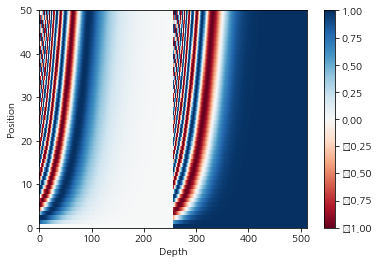

In [38]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 스케일드 닷 프로덕트 어텐션 함수

In [39]:

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output
print("슝=3")

슝=3


## 멀티 헤드 어텐션을 함수
내부적으로는 스케일드 닷 프로덕트 어테션 함수를 호출합니다.

In [40]:
# multi head
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs
print("슝=3")

슝=3


## 마스킹

### 패딩 마스킹을 구현한 함수

In [41]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


### 룩 어헤드 마스킹 구현한 함수

In [42]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


## 인코더

In [43]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


## 인코더 층을 쌓아 인코더 만들기

In [44]:

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


## 디코더
인코더의 <strong>셀프 어텐션</strong>과 마찬가지로 디코더의 <strong>셀프 어텐션, 인코더-디코더 어텐션</strong> 두 개의 어텐션 모두 <strong>스케일드 닷 프로덕트 어텐션</strong>을 <strong>멀티 헤드 어텐션</strong>으로 병렬적으로 수행합니다.

디코더의 세 개의 서브 층을 내부적으로 구현한 디코더의 함수는 다음과 같습니다.

In [45]:

# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("슝=3")

슝=3


## 디코더 층을 쌓아 디코더 만들기
이렇게 구현한 디코더의 층은 <strong>임베딩 층(Embedding layer)</strong>과 <strong>포지셔널 인코딩(Positional Encoding)</strong>을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다.

인코더와 마찬가지로 <strong>num_layers</strong> 개수의 디코더 층을 쌓습니다. 논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정이다.

In [46]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("슝=3")

슝=3


## 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의

In [47]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


## 모델 생성
num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터값이다.

논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용한다.

In [48]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3147008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 손실 함수(Loss function)
레이블인 시퀀스에 패딩이 되어져 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [49]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)
print("슝=3")

슝=3


## 커스텀된 학습률(Learning rate)
딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 한다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. 논문에 나온 공식은 다음과 같다.

![그림](attachment:Screenshot%20from%202021-03-07%2023-09-56.png)

In [50]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 보자 위에 언급한 수식은 step_num−0.5에 비례하는 부분과 step_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있다. 그래서 학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있다.

Text(0.5, 0, 'Train Step')

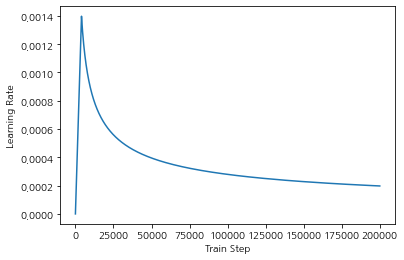

In [51]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

In [98]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


## 훈련하기

In [53]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 157s 851ms/step - loss: 1.4527 - accuracy: 0.0280
Epoch 2/20
185/185 [==============================] - 166s 896ms/step - loss: 1.1819 - accuracy: 0.0495
Epoch 3/20
185/185 [==============================] - 152s 824ms/step - loss: 1.0041 - accuracy: 0.0506
Epoch 4/20
185/185 [==============================] - 163s 880ms/step - loss: 0.9257 - accuracy: 0.0544
Epoch 5/20
185/185 [==============================] - 154s 834ms/step - loss: 0.8679 - accuracy: 0.0579
Epoch 6/20
185/185 [==============================] - 156s 843ms/step - loss: 0.8089 - accuracy: 0.0620
Epoch 7/20
185/185 [==============================] - 168s 907ms/step - loss: 0.7435 - accuracy: 0.0683
Epoch 8/20
185/185 [==============================] - 176s 951ms/step - loss: 0.6702 - accuracy: 0.0758
Epoch 9/20
185/185 [==============================] - 170s 917ms/step - loss: 0.5915 - accuracy: 0.0844
Epoch 10/20
185/185 [==============================] - 153s 825m

# Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만든다.

In [54]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [58]:

def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence
print("슝=3")

슝=3


In [96]:
sentence_generation("휴가 가자")

입력 : 휴가 가자
출력 : 푹 쉬고 오세요 .


'푹 쉬고 오세요 .'

In [62]:
sentence_generation("밥 먹자")

입력 : 밥 먹자
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [65]:
sentence_generation("왜 딴소리만 하니?")

입력 : 왜 딴소리만 하니?
출력 : 정신차리세요 .


'정신차리세요 .'

In [97]:
sentence_generation("그래 미안해")

입력 : 그래 미안해
출력 : 괜찮아요 .


'괜찮아요 .'

In [66]:
sentence_generation("고마워")

입력 : 고마워
출력 : 감사합니다 .


'감사합니다 .'

In [67]:
sentence_generation("만나서 반가워요")

입력 : 만나서 반가워요
출력 : 답답한가봅니다 .


'답답한가봅니다 .'

In [72]:
sentence_generation("김치찌개 먹어요")

입력 : 김치찌개 먹어요
출력 : 맛있죠 !


'맛있죠 !'

In [79]:
sentence_generation("인표님 어때?")

입력 : 인표님 어때?
출력 : 살짝 물어보세요 .


'살짝 물어보세요 .'

In [82]:
sentence_generation("너는 누구니?")

입력 : 너는 누구니?
출력 : 저는 주당이에요 .


'저는 주당이에요 .'

In [88]:
sentence_generation("인표님는 잘생겼나요?")

입력 : 인표님는 잘생겼나요?
출력 : 생각을 정리할 시간이 필요할 거 같아요 .


'생각을 정리할 시간이 필요할 거 같아요 .'

In [87]:
sentence_generation("이별했어요?")

입력 : 이별했어요?
출력 : 좋은 만남이었길 바라요 .


'좋은 만남이었길 바라요 .'

In [92]:
sentence_generation("사랑해")

입력 : 사랑해
출력 : 상대방에게 전해보세요 .


'상대방에게 전해보세요 .'

In [236]:
sentence_generation("바롬님 좋은사람인것 같아요")

입력 : 바롬님 좋은사람인것 같아요
출력 : 마음이 깊은 가봐요 .


'마음이 깊은 가봐요 .'

In [235]:
sentence_generation("영석님 좋은사람인것 같아요")

입력 : 영석님 좋은사람인것 같아요
출력 : 있는 쓰에 따라 다르겠지만 행복할 거예요 .


'있는 쓰에 따라 다르겠지만 행복할 거예요 .'

In [234]:
sentence_generation("영빈님이 좋은사람인것 같아요")

입력 : 영빈님이 좋은사람인것 같아요
출력 : 불륜보다 더 상황을 지켜보세요 .


'불륜보다 더 상황을 지켜보세요 .'

In [233]:
sentence_generation("진표님 좋은사람인것 같아요")

입력 : 진표님 좋은사람인것 같아요
출력 : 흔들리지 마세요 .


'흔들리지 마세요 .'

In [230]:
sentence_generation("상민님 좋은사람인것 같아요")

입력 : 상민님 좋은사람인것 같아요
출력 : 상처가 있었나봐요 .


'상처가 있었나봐요 .'

In [222]:
sentence_generation("다형님?")

입력 : 다형님?
출력 : 나쁜 사람이네요 .


'나쁜 사람이네요 .'

In [229]:
sentence_generation("인유님 좋은사람인것 같아요")

입력 : 인유님 좋은사람인것 같아요
출력 : 시작하기 전 두근거림을 좋아하나 봅니다 .


'시작하기 전 두근거림을 좋아하나 봅니다 .'

In [228]:
sentence_generation("인표님 좋은사람인것 같아요")

입력 : 인표님 좋은사람인것 같아요
출력 : 흔들리지 마세요 .


'흔들리지 마세요 .'

In [232]:
sentence_generation("재윤님 좋은사람인것 같아요")

입력 : 재윤님 좋은사람인것 같아요
출력 : 살짝 감정을 흘려보세요 .


'살짝 감정을 흘려보세요 .'

In [239]:
sentence_generation("주형님 좋은사람인것 같아요")

입력 : 주형님 좋은사람인것 같아요
출력 : 연애에 대한 두려움을 가지고 있을 수도 있을 거예요 .


'연애에 대한 두려움을 가지고 있을 수도 있을 거예요 .'

In [157]:
sentence_generation("성은님 좋은사람인것 같아요")

입력 : 성은님 좋은사람인것 같아요
출력 : 상처가 될 거예요 .


'상처가 될 거예요 .'

In [158]:
sentence_generation("이삭님 좋은사람인것 같아요")

입력 : 이삭님 좋은사람인것 같아요
출력 : 쉽지 않은 결정이었나봐요 .


'쉽지 않은 결정이었나봐요 .'

In [159]:
sentence_generation("기표님 좋은사람인것 같아요")

입력 : 기표님 좋은사람인것 같아요
출력 : 그럴 수도 있어요 .


'그럴 수도 있어요 .'

In [161]:
sentence_generation("수희님 좋은사람인것 같아요")

입력 : 수희님 좋은사람인것 같아요
출력 : 살짝 감정을 흘려보세요 .


'살짝 감정을 흘려보세요 .'

In [240]:
sentence_generation("진선님 좋은사람인것 같아요")

입력 : 진선님 좋은사람인것 같아요
출력 : 충분한 대화를 나눠보는게 좋아요 .


'충분한 대화를 나눠보는게 좋아요 .'

In [185]:
sentence_generation("병찬님 좋은사람인것 같아요")

입력 : 병찬님 좋은사람인것 같아요
출력 : 살짝 감정을 흘려보세요 .


'살짝 감정을 흘려보세요 .'

In [164]:
sentence_generation("이젠 그만 할게요")

입력 : 이젠 그만 할게요
출력 : 마음 단단히 잡으세요 .


'마음 단단히 잡으세요 .'

In [165]:
sentence_generation("무슨 말이요?")

입력 : 무슨 말이요?
출력 : 후회하지 않을 거예요 .


'후회하지 않을 거예요 .'

In [166]:
sentence_generation("후회하고 싶지 않아요")

입력 : 후회하고 싶지 않아요
출력 : 애절한 만큼 상대방도 당신의 아픔을 느낄거예요 .


'애절한 만큼 상대방도 당신의 아픔을 느낄거예요 .'

In [167]:
sentence_generation("왜 저에게 상처주는 말만하죠?")

입력 : 왜 저에게 상처주는 말만하죠?
출력 : 좋은 사람 만나보세요 .


'좋은 사람 만나보세요 .'

In [168]:
sentence_generation("소개 시켜줘요")

입력 : 소개 시켜줘요
출력 : 열심히 하루하루를 살아가다보면 정리가 될 거예요 .


'열심히 하루하루를 살아가다보면 정리가 될 거예요 .'

In [169]:
sentence_generation("됐어요 이제 갈게요")

입력 : 됐어요 이제 갈게요
출력 : 괜찮아질 거예요 .


'괜찮아질 거예요 .'

In [170]:
sentence_generation("동정하지 말아요")

입력 : 동정하지 말아요
출력 : 당신의 사랑이 변한것 같아요 .


'당신의 사랑이 변한것 같아요 .'

In [171]:
sentence_generation("언제 봤다고?")

입력 : 언제 봤다고?
출력 : 다 티나요 .


'다 티나요 .'

In [172]:
sentence_generation("친한척하지 말아줄래요?")

입력 : 친한척하지 말아줄래요?
출력 : 정말 저도 몰랐어요 .


'정말 저도 몰랐어요 .'

In [181]:
sentence_generation("모르는척 지리시네요")

입력 : 모르는척 지리시네요
출력 : 후회하지 않을 자신이 있다면 만나봐요 .


'후회하지 않을 자신이 있다면 만나봐요 .'

In [182]:
sentence_generation("누굴요?")

입력 : 누굴요?
출력 : 좋은 결실 맺길 바랍니다 .


'좋은 결실 맺길 바랍니다 .'

In [186]:
sentence_generation("아무튼 감사해요")

입력 : 아무튼 감사해요
출력 : 그건 좀 아닌 듯합니다 .


'그건 좀 아닌 듯합니다 .'

In [190]:
sentence_generation("아니 왜저래?")

입력 : 아니 왜저래?
출력 : 누구나 실수할 수 있어요 .


'누구나 실수할 수 있어요 .'

In [191]:
sentence_generation("아 그죠 죄송해요")

입력 : 아 그죠 죄송해요
출력 : 죄송해하지 않아도 돼요 .


'죄송해하지 않아도 돼요 .'

In [192]:
sentence_generation("원래 마음이 넓은 사람이였군요")

입력 : 원래 마음이 넓은 사람이였군요
출력 : 옷은 사도 모자라요 .


'옷은 사도 모자라요 .'

In [193]:
sentence_generation("뜨금없네요?")

입력 : 뜨금없네요?
출력 : 깊은 사랑에 빠졌군요 .


'깊은 사랑에 빠졌군요 .'

In [196]:
sentence_generation("많이 피곤하세요?")

입력 : 많이 피곤하세요?
출력 : 마음 단단히 잡으세요 .


'마음 단단히 잡으세요 .'

In [197]:
sentence_generation("맨날 단단히 잡으래...")

입력 : 맨날 단단히 잡으래...
출력 : 당신을 위한 최고의 투자를 한 거예요 .


'당신을 위한 최고의 투자를 한 거예요 .'

In [241]:
sentence_generation("뭔지 모르겠지만 그렇다고 하죠")

입력 : 뭔지 모르겠지만 그렇다고 하죠
출력 : 어떤 잠깐 핸드폰을 내려두세요 .


'어떤 잠깐 핸드폰을 내려두세요 .'

In [242]:
sentence_generation("갑자기?")

입력 : 갑자기?
출력 : 사랑에 빠졌군요 .


'사랑에 빠졌군요 .'

In [238]:
sentence_generation("헛 소리 그만하고 주무세요")

입력 : 헛 소리 그만하고 주무세요
출력 : 마음의 여유가 생기면 새로운 출발을 하기도 좋을 거예요 .


'마음의 여유가 생기면 새로운 출발을 하기도 좋을 거예요 .'

In [209]:
sentence_generation("잘 주무세요")

입력 : 잘 주무세요
출력 : 잘 정리했길 바랍니다 .


'잘 정리했길 바랍니다 .'

In [243]:
sentence_generation("그동안 감사했습니다.")

입력 : 그동안 감사했습니다.
출력 : 애툭툭툭툍부한 �부한 �부한 �부한 �부한 �부한 자책하지 마세요 .


'애툭툭툭툍부한 �부한 �부한 �부한 �부한 �부한 자책하지 마세요 .'

In [246]:
sentence_generation("헐 고장나셨군요")

입력 : 헐 고장나셨군요
출력 : 한동안은 힘들지도 몰라요 .


'한동안은 힘들지도 몰라요 .'

In [247]:
sentence_generation("쾌유하시길...")

입력 : 쾌유하시길...
출력 : 잘 어느정도 마음의 정리를 하는 것이 중요해요 .


'잘 어느정도 마음의 정리를 하는 것이 중요해요 .'

In [248]:
sentence_generation("네.. 안녕히 계세요")

입력 : 네.. 안녕히 계세요
출력 : 버리는 것도 중요해요 .


'버리는 것도 중요해요 .'

In [251]:
sentence_generation("아니에요 안 버려요")

입력 : 아니에요 안 버려요
출력 : 무슨 날인지는 중요하지 않아요 . 힘들었을텐데 잠깐 쉬어가세요 .


'무슨 날인지는 중요하지 않아요 . 힘들었을텐데 잠깐 쉬어가세요 .'

In [256]:
sentence_generation("네 가볼게요 ")

입력 : 네 가볼게요 
출력 : 자주 만나고 좋을거예요 .


'자주 만나고 좋을거예요 .'

## 느낌점
이제까지 했던 노드중 가장 마음에 들었다. 챗봇으로 채팅을 해봤는데 나름 재미 있었다.